# Install deps

In [ ]:
! pip install -r requirements.txt

#### Create a local_secrets.py file containing the following details: 
###### client_id=\<YOUR_CLIENT_ID\> 
###### client_secret=\<YOUR_SECRET_ID\>
###### token=\<YOUR_TOKEN\>
###### db_keyspace=\<YOUR_KEYSPACE_NAME\>
###### secure_bundle_path=\<FULL_PATH_TO_YOUR_SECURITY_BUNDLE.zip\>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
from local_secrets import *
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

## Renaming data

In [3]:
orig_data = pd.read_csv('./data/DELL.csv')
new_headers = {'Date': 'date', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Adj Close': 'adj_close', 'Volume': 'volume'}
data = orig_data.rename(columns=new_headers)

## Inserting data into the DB

In [6]:
## Astra Configuration
cloud_config= {
  'secure_connect_bundle': secure_bundle_path
}
auth_provider = PlainTextAuthProvider(client_id, client_secret)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

session.execute(f'USE {db_keyspace}')

### 1. create training_data table

In [7]:
query = """
CREATE TABLE IF NOT EXISTS training_data (
    date text,
    open float,
    high float,
    low float,
    close float,
    adj_close float,
    volume float,
    PRIMARY KEY (date)
)
"""
session.execute(query)

### 1. Inserting data into training_data

In [8]:
for row in data.itertuples(index=False):
    query = f"INSERT INTO training_data (date, open, high, low, close, adj_close, volume) VALUES ('{row[0]}', {row[1]}, {row[2]}, {row[3]}, {row[4]}, {row[5]}, {row[6]})"
    session.execute(query)

## Retrieving data from Astra DB

In [9]:
# Retrieve data from the table
query = "SELECT * FROM training_data"
result_set = session.execute(query)

# Convert the result set to a pandas DataFrame
data = pd.DataFrame(list(result_set)).sort_values(by=['date'])

## Data Statistics

In [10]:
print(data.shape)
print(data.sample(7))

(1824, 7)
                     date  adj_close      close       high        low  \
1518           2018-09-27  53.848282  53.848282  53.870430  53.361019   
447            2017-08-30  41.101883  41.101883  41.140644  40.415283   
976   2016-08-25 00:00:00  25.609081  24.972315  25.143965  25.609081   
643   2016-12-01 00:00:00  29.651163  28.383167  28.726467  29.706533   
1697           2019-10-08  48.810001  48.810001  50.369999  48.790001   
1318  2019-05-01 00:00:00  67.900002  67.410004  68.580002  69.199997   
177            2017-06-15  34.246956  34.246956  34.285713  33.648949   

           open     volume  
1518  53.433002  2256400.0  
447   40.470654  1830500.0  
976   25.143965   188300.0  
643   28.726467  4062700.0  
1697  50.189999  1529200.0  
1318  68.580002  2084500.0  
177   34.197121  3584100.0  


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1824 entries, 473 to 885
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1824 non-null   object 
 1   adj_close  1824 non-null   float64
 2   close      1824 non-null   float64
 3   high       1824 non-null   float64
 4   low        1824 non-null   float64
 5   open       1824 non-null   float64
 6   volume     1824 non-null   float64
dtypes: float64(6), object(1)
memory usage: 114.0+ KB


In [12]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1824 entries, 473 to 885
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1824 non-null   datetime64[ns]
 1   adj_close  1824 non-null   float64       
 2   close      1824 non-null   float64       
 3   high       1824 non-null   float64       
 4   low        1824 non-null   float64       
 5   open       1824 non-null   float64       
 6   volume     1824 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 114.0 KB


#### Open and Close prices over time for DELL Stock Markets

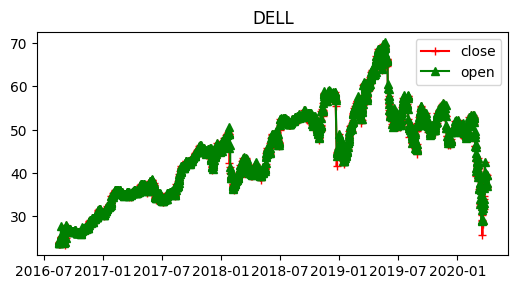

In [13]:
data['date'] = pd.to_datetime(data['date'])
companies = ['DELL', 'GOOGL']
company = 'DELL'
plt.figure(figsize=(15, 8))
plt.subplot(3, 3, 1)
# date vs open
plt.plot(data['date'], data['close'], c="r", label="close", marker="+")
# date vs close
plt.plot(data['date'], data['open'], c="g", label="open", marker="^")
plt.title(company)
plt.legend()
plt.tight_layout()

#### Volume of shares traded per a price level for DELL Company

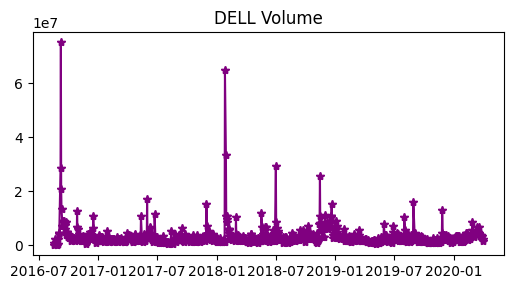

In [14]:
plt.figure(figsize=(15, 8))
#for index, company in enumerate(companies, 1):
plt.subplot(3, 3, 1)
plt.plot(data['date'], data['volume'], c='purple', marker='*')
plt.title(f"{company} Volume")
plt.tight_layout()

#### Dell Stock (Close) Prices over time

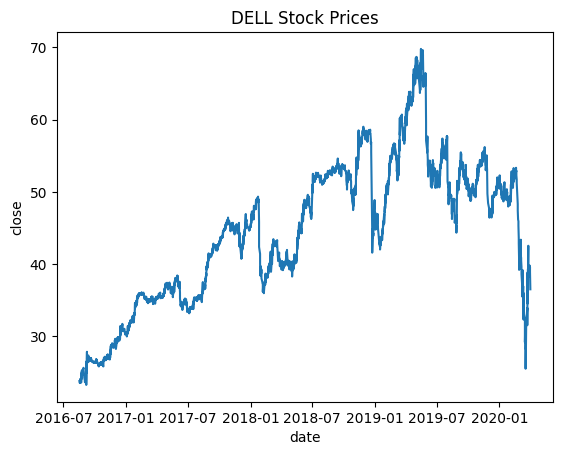

In [15]:
dell = data
prediction_range = dell.loc[(dell['date'] > datetime(2013,1,1))
 & (dell['date']<datetime(2018,1,1))]
plt.plot(dell['date'],dell['close'])
plt.xlabel("date")
plt.ylabel("close")
plt.title("DELL Stock Prices")
plt.show()

#### splitting data into 95% training and 5% test

In [16]:
close_data = dell.filter(['close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)

1733


## Building the model

#### Applying the train test split on the data and normalizing the values (betwen 0 and 1)

In [17]:
from sklearn.preprocessing import MinMaxScaler
 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
 
train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []
 
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

#### Defining the model: LSTM model

In [18]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))

#### Defining the optimizer and running the fit / trainning operation

In [19]:
model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10)

Epoch 1/10
53/53 [==============================] - 2s 23ms/step - loss: 0.0266
Epoch 2/10
53/53 [==============================] - 1s 22ms/step - loss: 0.0108
Epoch 3/10
53/53 [==============================] - 1s 23ms/step - loss: 0.0102
Epoch 4/10
53/53 [==============================] - 1s 23ms/step - loss: 0.0096
Epoch 5/10
53/53 [==============================] - 1s 23ms/step - loss: 0.0086
Epoch 6/10
53/53 [==============================] - 1s 23ms/step - loss: 0.0082
Epoch 7/10
53/53 [==============================] - 1s 23ms/step - loss: 0.0081
Epoch 8/10
53/53 [==============================] - 1s 23ms/step - loss: 0.0073
Epoch 9/10
53/53 [==============================] - 1s 23ms/step - loss: 0.0065
Epoch 10/10
53/53 [==============================] - 1s 28ms/step - loss: 0.0069


#### Runining the predict or test operation on the test dataset and compute error metrics (RMSE and MSE)

In [20]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
 
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
 
# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
 
# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
rmse = np.sqrt(mse)
print("MSE", mse)
print("RMSE", rmse)

3/3 [==============================] - 0s 6ms/step
MSE 8.869980720642591
RMSE 2.9782512856779886


## Forecast vs Sales

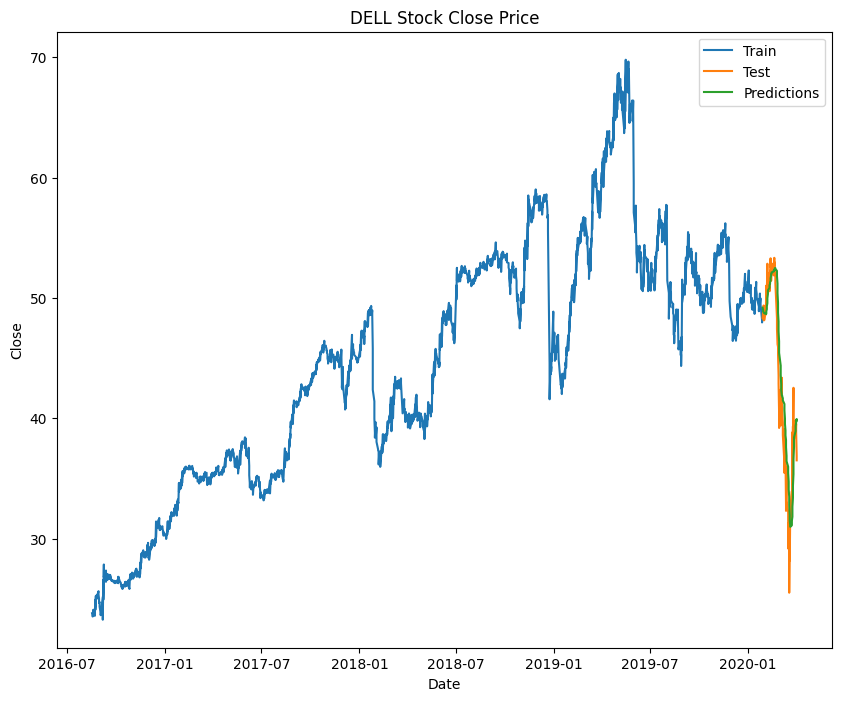

In [21]:
train = dell[:training]
test = dell[training:]
test['Predictions'] = predictions
 
plt.figure(figsize=(10, 8))
plt.plot(train['date'], train['close'])
plt.plot(test['date'], test[['close', 'Predictions']])
plt.title('DELL Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])

#### Print the summary of the model

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52033 (203.25 KB)
Trainable params: 52033 (203.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
model_table_name="model_table"

#### Store the model in AstraDB with the error metrics

In [24]:
session.execute(f"CREATE TABLE IF NOT EXISTS {model_table_name} (model_name TEXT PRIMARY KEY, model_data BLOB, rmse double, mse double);")

In [25]:
import io
model_json = model.to_json()

In [26]:
import json
prepared_stmt = session.prepare(f"""
    INSERT INTO {model_table_name} (model_name, model_data, rmse, mse)
    VALUES (?, ?, ?, ?)
""")

model_name = 'demo_model_h5'  # Replace with your desired model name

session.execute(prepared_stmt, (model_name, bytearray(json.dumps(model_json).encode('utf-8')), rmse, mse))

#### read the stored model and load it again

In [27]:
model_output = session.execute(f"select model_data from {model_table_name} where model_name='{model_name}';")

In [28]:
json_blob = None
for row in model_output:
    json_blob = row.model_data

if json_blob is None:
    raise ValueError(f"model with name '{model_name}' not found in the database.")

# Decode the blob data to string
decoded_json_blob = json_blob.decode('utf-8')

# Parse the JSON string into a JSON object
json_data = json.loads(decoded_json_blob)

In [29]:
# Create a new model with the same architecture
loaded_model = tf.keras.models.model_from_json(json_data)

In [30]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52033 (203.25 KB)
Trainable params: 52033 (203.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
new_predictions = loaded_model.predict(x_test)
new_predictions = scaler.inverse_transform(new_predictions)

print(new_predictions[:5])

3/3 [==============================] - 0s 9ms/step
[[25.57497 ]
 [25.564266]
 [25.55626 ]
 [25.54873 ]
 [25.544725]]
